In [ ]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
from sklearn.metrics import mean_absolute_error, r2_score

In [ ]:
def load_housing_data():
  tarball_path = Path("datasets/housing.tgz")
  if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url,tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
  return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

In [ ]:
# housing = pd.read_csv("housing.csv")

In [ ]:
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [ ]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [ ]:
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

In [ ]:
IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
  path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
  if tight_layout:
    plt.tight_layout()
  plt.savefig(path, format=fig_extension, dpi=resolution)

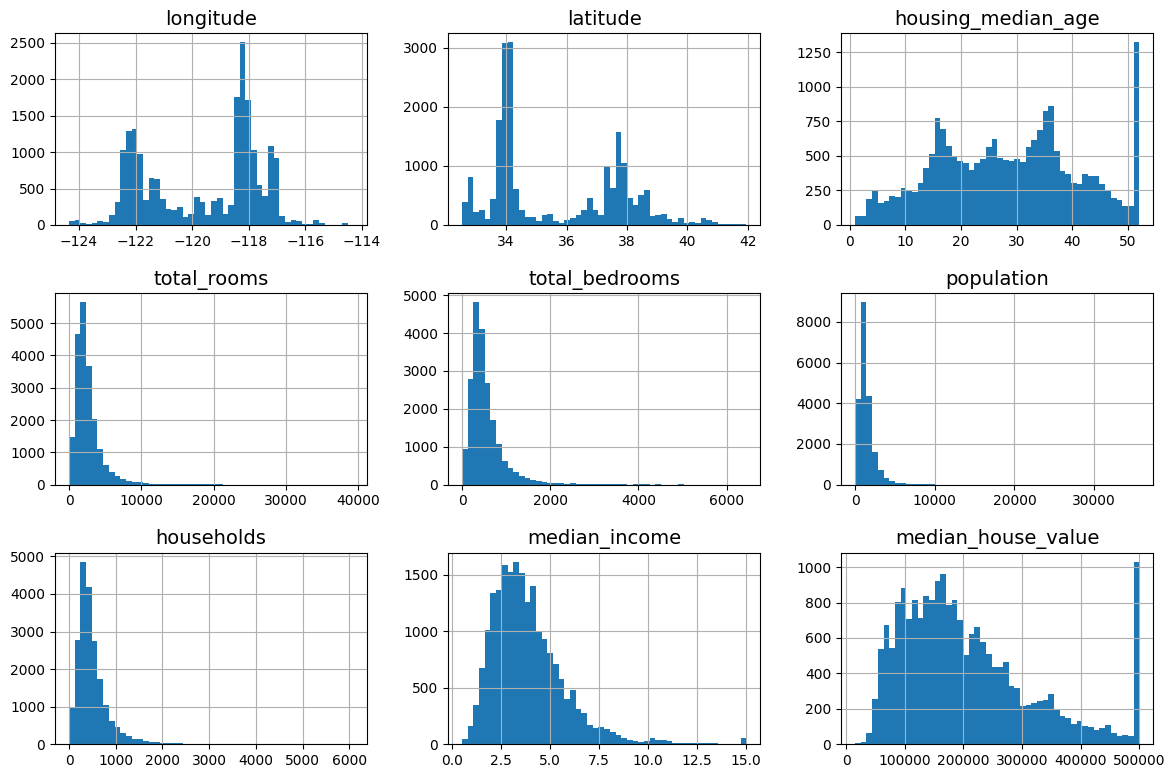

In [ ]:
import matplotlib.pyplot as plt

plt.rc("font", size=14)
plt.rc("axes", labelsize=14, titlesize=14)
plt.rc("legend", fontsize=14)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)

housing.hist(bins=50, figsize=(12,8))
save_fig("attribute_histogram_plots")
plt.show()

In [ ]:
import numpy as np

def shuffle_and_split_data(data,test_ratio):
    shuffled_indcies = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indcies[:test_set_size]
    train_indices = shuffled_indcies[test_set_size:]
    return data.iloc[train_indices],data.iloc[test_indices]

train_set, test_set = shuffle_and_split_data(housing, 0.2)
print(f"Train set:{len(train_set)} \nTest set:{len(test_set)}")

Train set:16512 
Test set:4128


In [ ]:
from zlib import crc32

def is_id_in_test_set(identifier,test_ratio):
    return crc32(np.int64(identifier))< test_ratio*2**32

def split_data_with_id_hash(data,test_ratio,id_column):
    ids =data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_,test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

housing_with_id = housing.reset_index()
train_set,test_set = split_data_with_id_hash(housing_with_id,0.2,"index")

In [ ]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set,test_set = split_data_with_id_hash(housing_with_id,0.2,"id")

In [ ]:
print(f"Train set:{len(train_set)} \nTest set:{len(test_set)}")

Train set:16322 
Test set:4318


In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing,test_size=0.2,random_state=42)

In [ ]:
print(f"Train set:{len(train_set)} \nTest set:{len(test_set)}")

Train set:16512 
Test set:4128


In [ ]:
test_set["total_bedrooms"].isnull().sum()

44

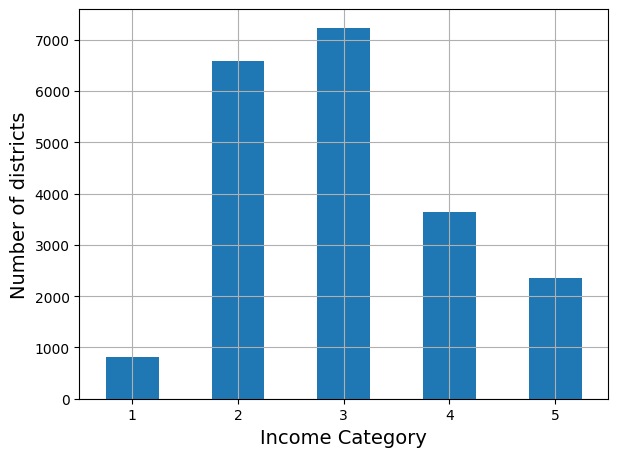

In [ ]:
housing["income_cat"]=pd.cut(housing["median_income"],
                            bins=[0,1.5,3,4.5,6,np.inf],
                            labels=[1,2,3,4,5])

housing["income_cat"].value_counts().sort_index().plot.bar(rot=0,grid=True)
plt.xlabel("Income Category")
plt.ylabel("Number of districts")
save_fig("housing_income_cat_bar_plot")
plt.show()

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits= []

for train_index, test_index in splitter.split(housing,housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

srtat_train_set, strat_test_set = strat_splits[0]

In [ ]:
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state = 42)

In [ ]:
strat_test_set["income_cat"].value_counts()/len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [ ]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(housing),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(test_set),
}).sort_index()
compare_props.index.name = "Income Category"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] /
                                   compare_props["Overall %"] - 1)
compare_props["Rand. Error %"] = (compare_props["Random %"] /
                                  compare_props["Overall %"] - 1)
(compare_props * 100).round(2)

Overall %  Stratified %  Random %  Strat. Error %  \
Income Category                                                      
1                     3.98          4.00      4.24            0.36   
2                    31.88         31.88     30.74           -0.02   
3                    35.06         35.05     34.52           -0.01   
4                    17.63         17.64     18.41            0.03   
5                    11.44         11.43     12.09           -0.08   

                 Rand. Error %  
Income Category                 
1                         6.45  
2                        -3.59  
3                        -1.53  
4                         4.42  
5                         5.63

In [ ]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat",axis=1, inplace=True)

In [ ]:
housing_main = housing

In [ ]:
housing = strat_train_set.copy()

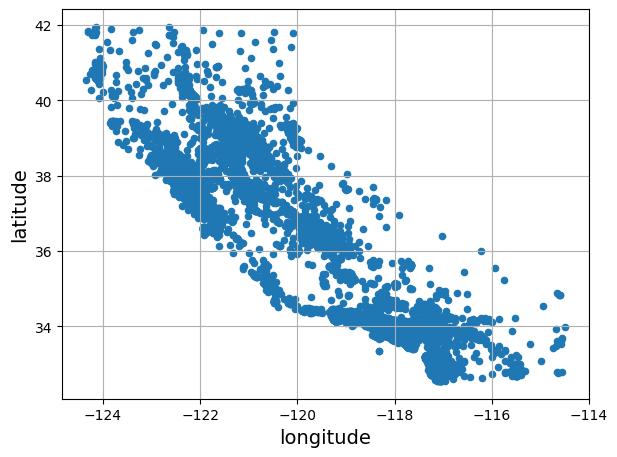

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True)
save_fig("bad_visualization_plot")
plt.show()

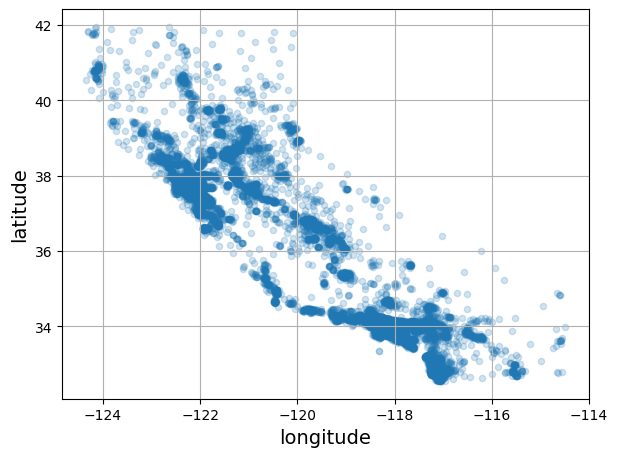

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
save_fig("better_visualization_plot")
plt.show()

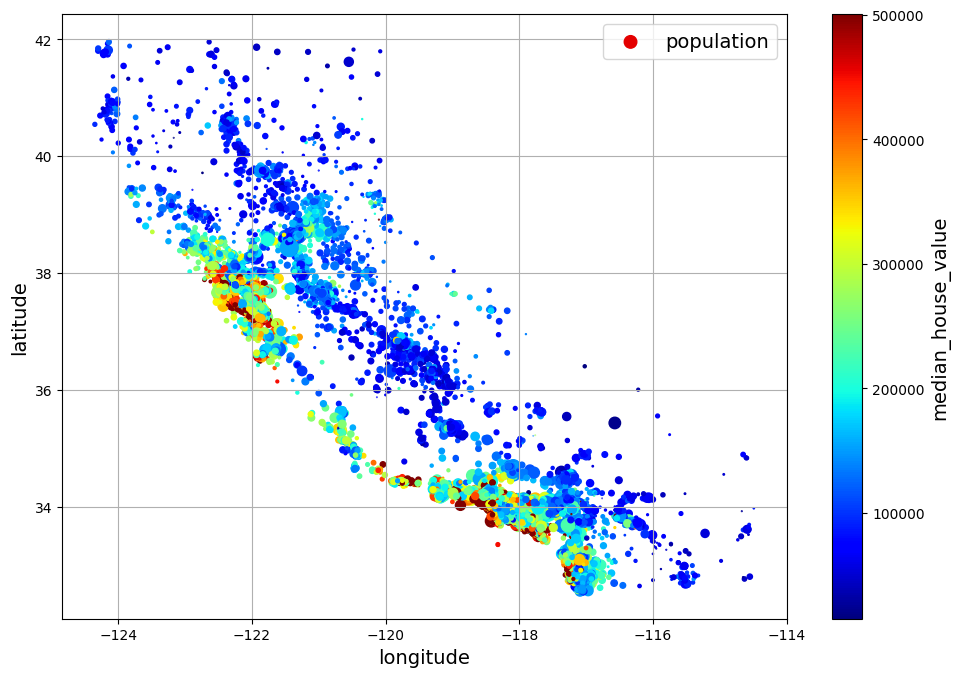

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude",
            grid=True, s=housing["population"]/100, label="population",
            c="median_house_value", cmap="jet", colorbar=True,
            legend=True, sharex=False,figsize=(10,7))
save_fig("housing_prices_scatterplot")
plt.show()

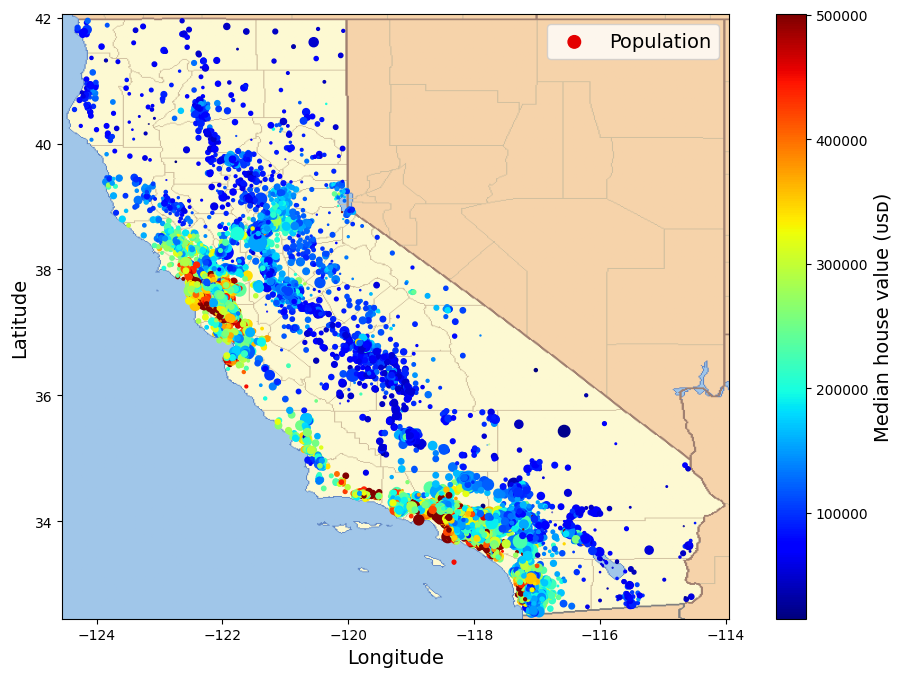

In [ ]:
filename = "california.png"
if not (IMAGES_PATH / filename).is_file():
  homl3_root = "https://github.com/ageron/handson-ml3/raw/main/"
  url = homl3_root + "images/end_to_end_project/" + filename
  print("Downloading", filename)
  urllib.request.urlretrieve(url, IMAGES_PATH / filename)

housing_renamed = housing.rename(columns={"latitude": "Latitude", "longitude": "Longitude",
                                          "population": "Population",
                                          "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude",
                     s= housing_renamed["Population"]/100, label="Population",
                     c="Median house value (ᴜsᴅ)", cmap="jet", colorbar="True",
                     legend=True, sharex=False, figsize=(10,7))

california_img = plt.imread(IMAGES_PATH / filename)
axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis)

save_fig("california_housing_prices_plot")
plt.show()

In [ ]:
corr_matrix = housing.corr(numeric_only=True)

corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

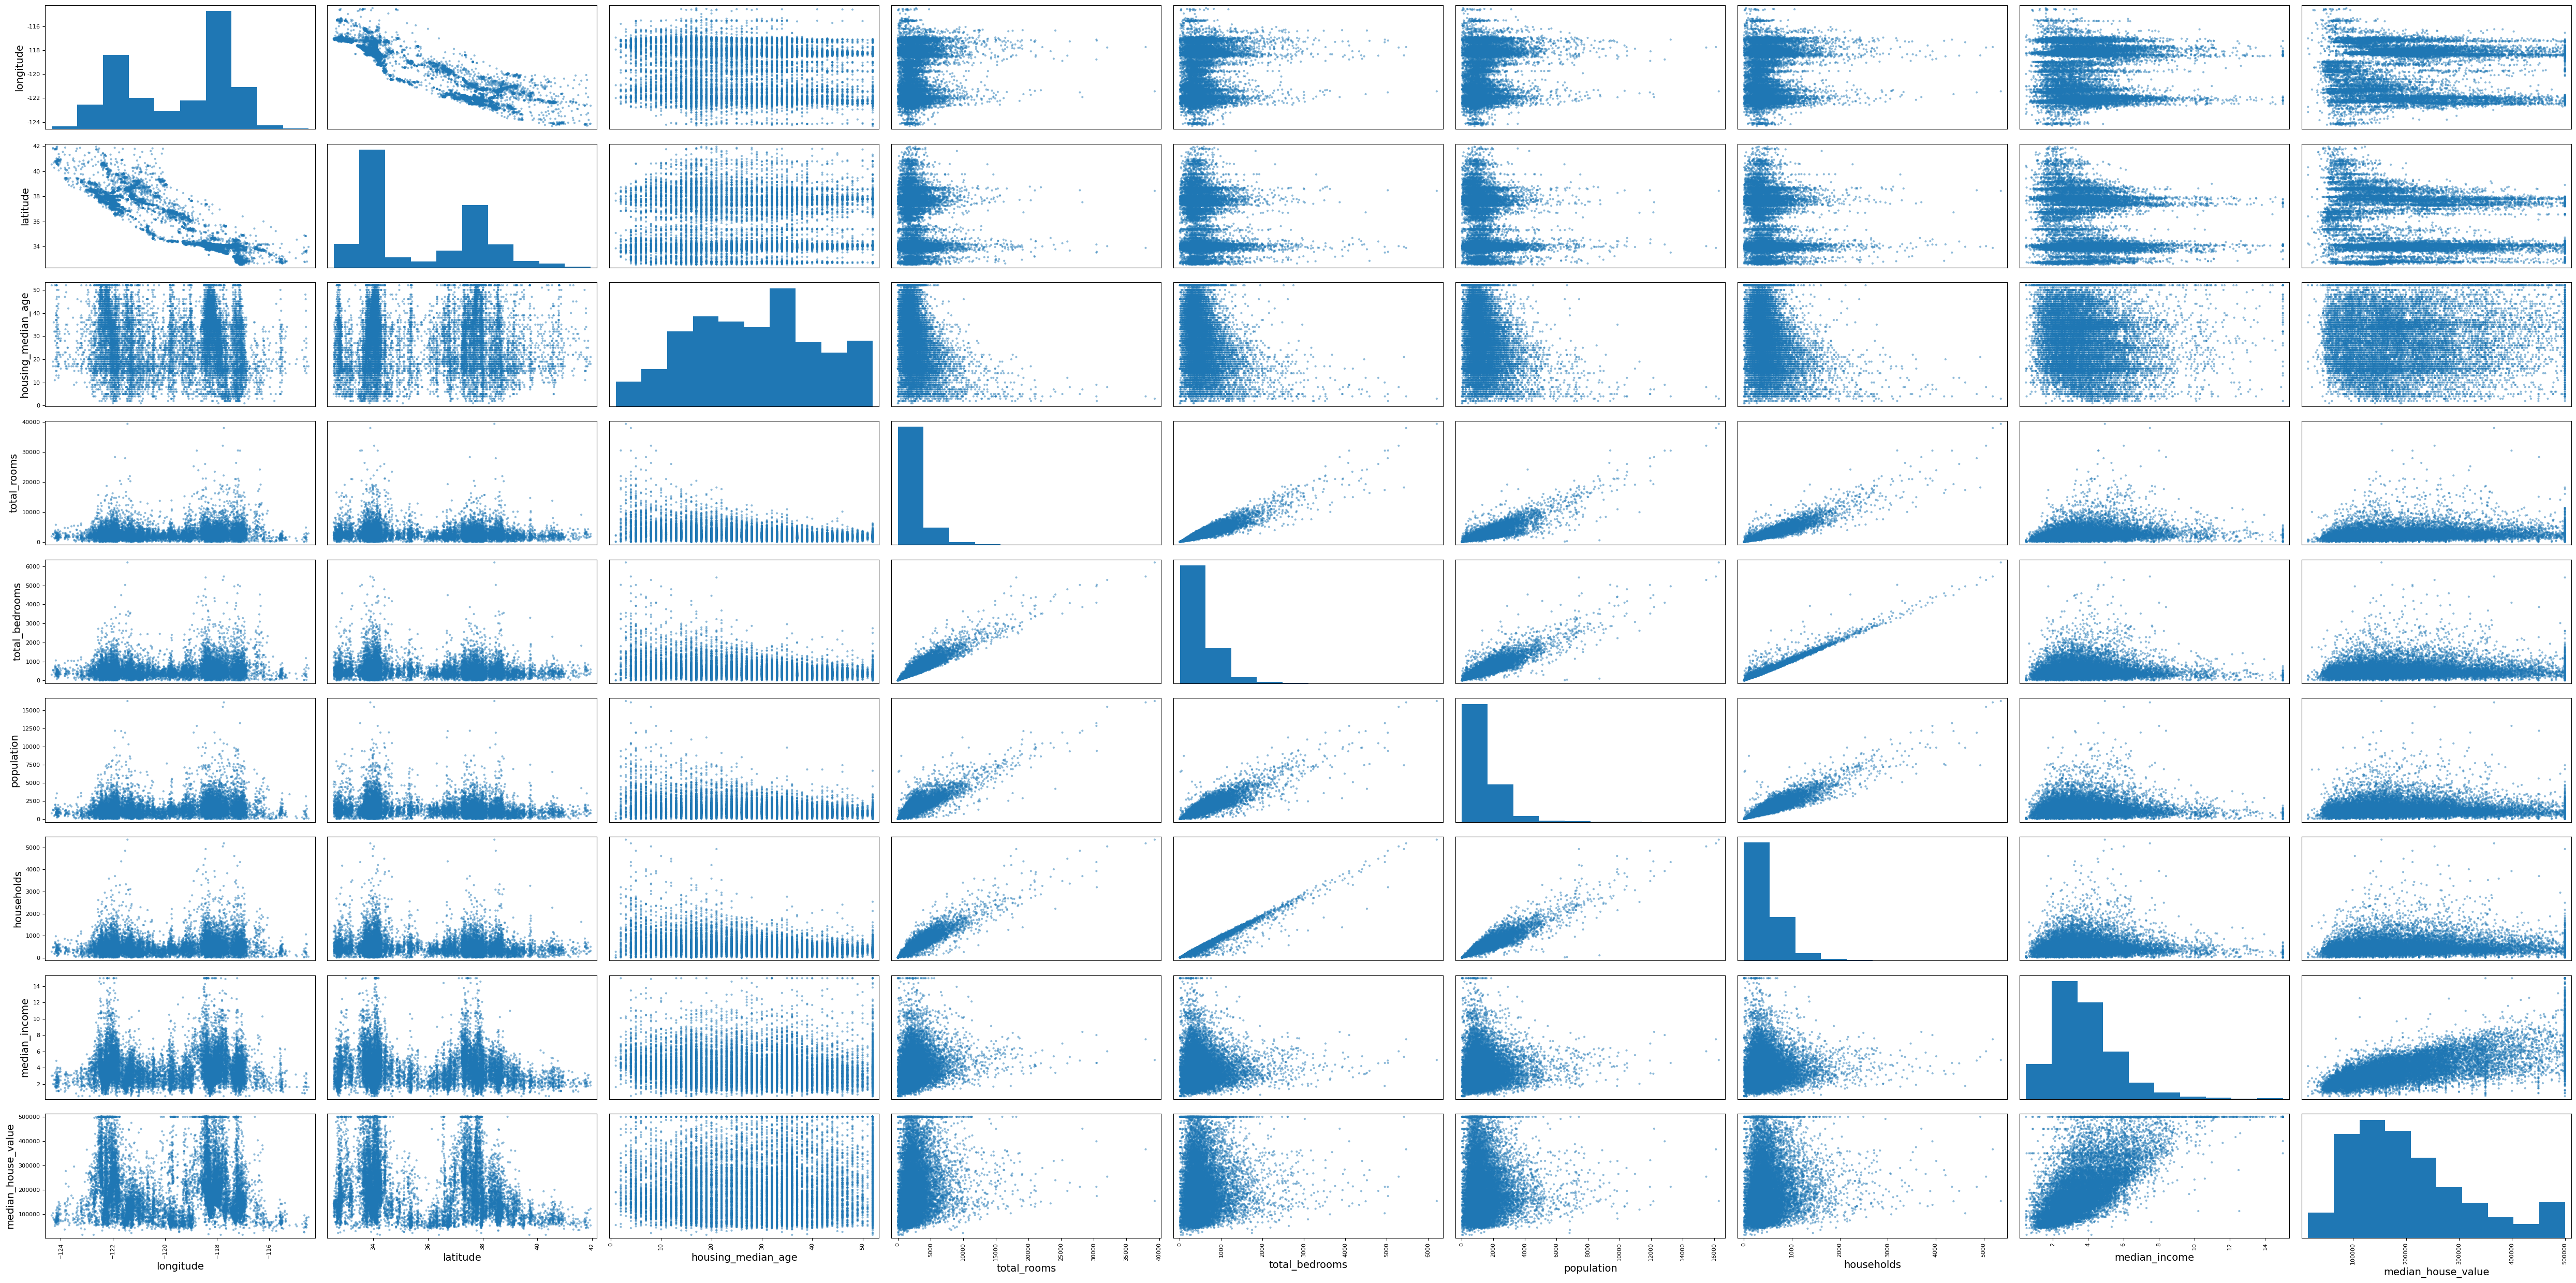

In [ ]:
from pandas.plotting import scatter_matrix

scatter_matrix(housing,figsize=(50,25))
save_fig("scatter_matrix_plot")
plt.show()

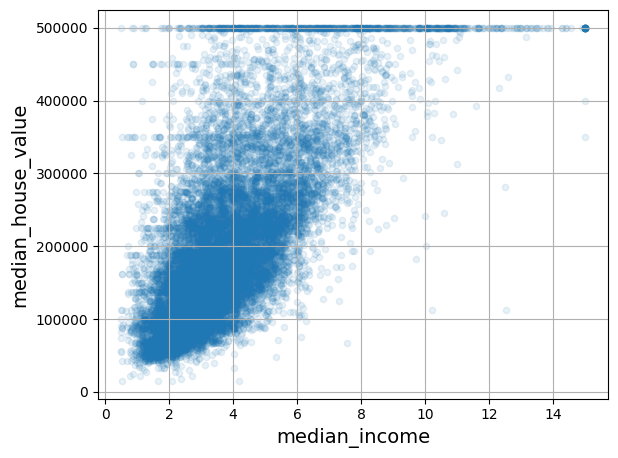

In [ ]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
            alpha=0.1, grid=True)
save_fig("income_vs_house_value_scaterplot")
plt.show()

In [ ]:
housing["rooms_per_house"]= housing["total_rooms"]/housing["households"]
housing["bedrooms_ratio"]= housing["total_bedrooms"]/housing["total_rooms"]
housing["people_perhouse"]= housing["population"]/housing["households"]

In [ ]:
corr_matrix= housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_perhouse      -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

In [ ]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [ ]:
median = housing["total_bedrooms"].median()
housing["total_bedrooms"]= housing["total_bedrooms"].fillna(median)

In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

In [ ]:
housing_num= housing.select_dtypes(include=[np.number])
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [ ]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [ ]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [ ]:
imputer.strategy

'median'

In [ ]:
X=imputer.transform(housing_num)

In [ ]:
imputer.feature_names_in_

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

In [ ]:
housing_tr = pd.DataFrame(X, columns= housing_num.columns,
                          index=housing_num.index)

In [ ]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(X)

In [ ]:
outlier_pred

array([-1,  1,  1, ...,  1,  1,  1])

In [ ]:
housing = housing.iloc[outlier_pred == 1]
housing_labels = housing_labels.iloc[outlier_pred == 1]

In [ ]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head()

ocean_proximity
14973       <1H OCEAN
3785           INLAND
14689          INLAND
20507      NEAR OCEAN
1286           INLAND

In [ ]:
housing_cat.value_counts()

ocean_proximity
<1H OCEAN          6577
INLAND             4526
NEAR OCEAN         1751
NEAR BAY           1592
ISLAND                2
Name: count, dtype: int64

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [ ]:
housing_cat_encoded[:8]

array([[0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.],
       [0.]])

In [ ]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [ ]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [ ]:
housing_cat_1hot

<14448x5 sparse matrix of type '<class 'numpy.float64'>'
	with 14448 stored elements in Compressed Sparse Row format>

In [ ]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [ ]:
cat_encoder = OneHotEncoder(sparse_output=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [ ]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [ ]:
df_test = pd.DataFrame({"ocean_proximity":["INLAND","NEAR BAY"]})
pd.get_dummies(df_test)

ocean_proximity_INLAND  ocean_proximity_NEAR BAY
0                    True                     False
1                   False                      True

In [ ]:
cat_encoder.transform(df_test)

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [ ]:
df_test_unknown = pd.DataFrame({"ocean_proximity":["<2H OCEAN","ISLAND"]})
pd.get_dummies(df_test_unknown)

ocean_proximity_<2H OCEAN  ocean_proximity_ISLAND
0                       True                   False
1                      False                    True

In [ ]:
cat_encoder.handle_unknown="ignore"
cat_encoder.transform(df_test_unknown)

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [ ]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [ ]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [ ]:
df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown),
                         columns=cat_encoder.get_feature_names_out(),
                         index=df_test_unknown.index)

In [ ]:
df_output

ocean_proximity_<1H OCEAN  ocean_proximity_INLAND  ocean_proximity_ISLAND  \
0                        0.0                     0.0                     0.0   
1                        0.0                     0.0                     1.0   

   ocean_proximity_NEAR BAY  ocean_proximity_NEAR OCEAN  
0                       0.0                         0.0  
1                       0.0                         0.0

In [ ]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1,1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

In [ ]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

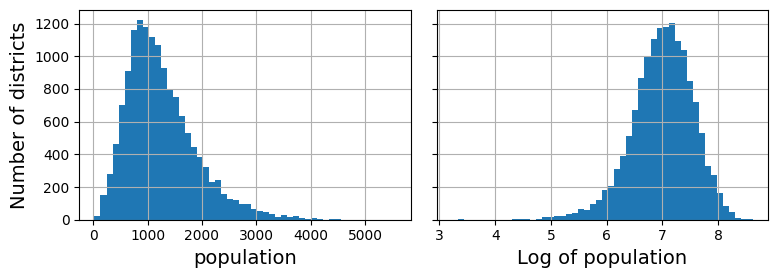

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8,3), sharey=True)
housing["population"].hist(ax=axs[0], bins=50)
housing["population"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")
save_fig("long_tail_plot")
plt.show()

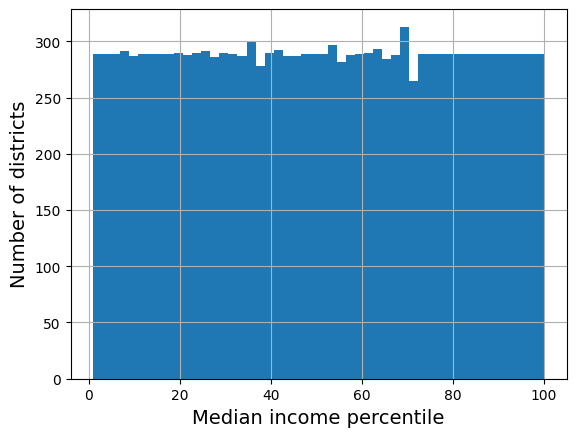

In [ ]:
percentiles = [np.percentile(housing["median_income"], p)
               for p in range(1, 100)]
flattened_median_income = pd.cut(housing["median_income"],
                                 bins=[-np.inf] + percentiles + [np.inf],
                                 labels=range(1, 100 + 1))
flattened_median_income.hist(bins=50)
plt.xlabel("Median income percentile")
plt.ylabel("Number of districts")
plt.show()

In [ ]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]],[[35]], gamma=0.1)

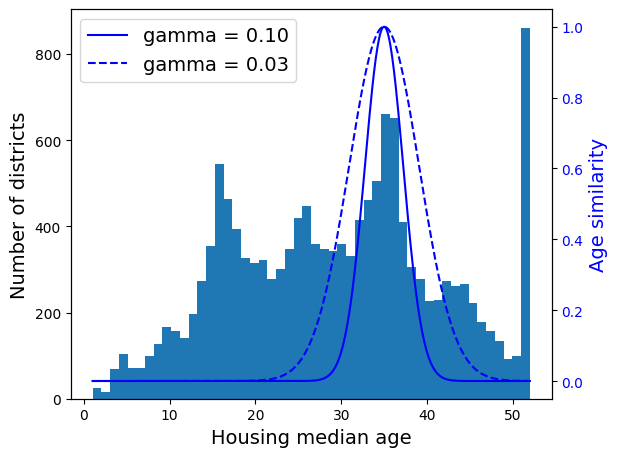

In [ ]:
ages = np.linspace(housing["housing_median_age"].min(),
                   housing["housing_median_age"].max(),
                   500).reshape(-1, 1)
gamma1 = 0.1
gamma2 = 0.03
rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2 = rbf_kernel(ages, [[35]], gamma=gamma2)

fig, ax1 = plt.subplots()

ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax1.hist(housing["housing_median_age"], bins=50)

ax2 = ax1.twinx()  # create a twin axis that shares the same x-axis
color = "blue"
ax2.plot(ages, rbf1, color=color, label="gamma = 0.10")
ax2.plot(ages, rbf2, color=color, label="gamma = 0.03", linestyle="--")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("Age similarity", color=color)

plt.legend(loc="upper left")
save_fig("age_similarity_plot")
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[["median_income"]],scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5]

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

In [ ]:
predictions

array([[307649.58358784],
       [143451.50154782],
       [135759.63057829],
       [192702.83891231],
       [184498.77560018]])

In [ ]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(),
                                   transformer=StandardScaler())
model.fit(housing[["median_income"]], housing_labels)
predictions = model.predict(some_new_data)


In [ ]:
predictions

array([307649.58358784, 143451.50154782, 135759.63057829, 192702.83891231,
       184498.77560018])

In [ ]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[["population"]])

In [ ]:
rbf_transformer = FunctionTransformer(rbf_kernel,
                                      kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])

In [ ]:
age_simil_35

array([[8.20849986e-02],
       [6.70320046e-01],
       [8.48904403e-15],
       ...,
       [9.55316054e-22],
       [6.70320046e-01],
       [3.03539138e-04]])

In [ ]:
sf_coords = 37.7749,-122.41
sf_transformer =FunctionTransformer(rbf_kernel,
                                    kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.transform(housing[["latitude","longitude"]])

In [ ]:
sf_simil

array([[0.05258419],
       [0.94864161],
       [0.01192662],
       ...,
       [0.00388525],
       [0.05038518],
       [0.99868067]])

In [ ]:
ratio_transformer = FunctionTransformer(lambda X:X[:,[0]]/X[:,[1]])
ratio_transformer.transform(np.array([[1.,2.],[3.,4.]]))

array([[0.5 ],
       [0.75]])

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
  def __init__(self, with_mean = True):
    self.with_mean =with_mean

  def fit(self, X, y=None):
    X = check_array(X)
    self.mean = X.mean(axis=0)
    self.scale_ = X.std(axis=0)
    self.n_features_in_ = X.shape[1]
    return self

  def transform(self,X):
    check_is_fitted(self)
    X = check_array(X)
    assert self.n_features_in_ == X.shape[1]
    if self.with_mean:
      X = X - self.mean_
    return X/self.scale_

In [ ]:
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
  def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
    self.n_clusters = n_clusters
    self.gamma = gamma
    self.random_state = random_state

  def fit(self, X, y=None, sample_weight=None):
    self.kmeans_ = KMeans(self.n_clusters, n_init=10, random_state=self.random_state)
    self.kmeans_.fit(X, sample_weight=sample_weight)
    return self

  def transform(self,X):
    return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

  def get_feature_names_out(self, names=None):
    return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [ ]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude","longitude"]], sample_weight=housing_labels)

In [ ]:
similarities[:3].round(2)

array([[0.  , 0.99, 0.  , 0.04, 0.  , 0.  , 0.  , 0.68, 0.11, 0.  ],
       [0.7 , 0.  , 0.  , 0.  , 0.29, 0.11, 0.45, 0.  , 0.  , 0.29],
       [0.  , 0.2 , 0.  , 0.5 , 0.  , 0.  , 0.  , 0.59, 0.  , 0.  ]])

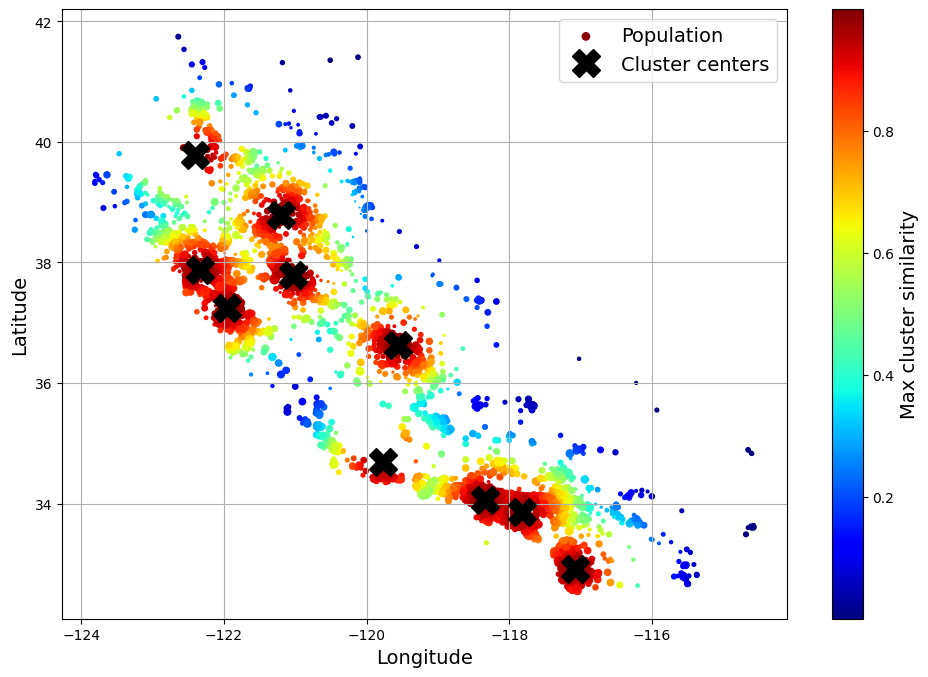

In [ ]:
housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")
save_fig("district_cluster_plot")
plt.show()

In [ ]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([("impute", SimpleImputer(strategy="median")),
                         ("standardize", StandardScaler())])

In [ ]:
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

In [ ]:
from sklearn import set_config

set_config(display="diagram")

num_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [ ]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

In [ ]:
df_housing_num_prepared=pd.DataFrame(housing_num_prepared,
                                     columns=num_pipeline.get_feature_names_out(),
                                     index=housing_num.index)

In [ ]:
num_pipeline.steps

[('simpleimputer', SimpleImputer(strategy='median')),
 ('standardscaler', StandardScaler())]

In [ ]:
num_pipeline[1]

StandardScaler()

In [ ]:
num_pipeline[:-1]

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median'))])

In [ ]:
num_pipeline.set_params(simpleimputer__strategy="median")

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [ ]:
df_housing_num_prepared

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
13096  -1.423037  1.013606            1.861119     0.311912        1.368167   
14973   0.596394 -0.702103            0.907630    -0.308620       -0.435925   
3785   -1.203098  1.276119            0.351428    -0.712240       -0.760709   
14689   1.231216 -0.884924           -0.919891     0.702262        0.742306   
20507   0.711362 -0.875549            0.589800     0.790125        1.595753   
...          ...       ...                 ...          ...             ...   
14207   0.586397 -0.833359            0.987087    -0.184147        0.140152   
13105   0.131525  0.319822           -0.443146     0.139847        0.128298   
19301   1.256209 -1.428701           -1.237721     0.586026        0.562134   
19121   0.586397 -0.739605            0.669257     0.522417        0.794461   
19888  -1.418038  0.947978            1.225459    -1.010608       -0.812864   

       population  households  median_income  
13096    0.137460    1.394812      -0.936491  
14973   -0.693771   -0.373485       1.171942  
3785    -0.788768   -0.775727      -0.759789  
14689    0.383175    0.731375      -0.850281  
20507    0.444376    1.755263      -0.180365  
...           ...         ...            ...  
14207   -0.445315    0.060101       0.444041  
13105   -0.005950    0.083608      -0.685630  
19301    1.268299    0.679135       0.101049  
19121    0.273563    0.882868       0.145396  
19888   -0.679156   -0.752219      -0.310341  

[16512 rows x 8 columns]

In [ ]:
from sklearn.compose import ColumnTransformer

num_attribs = ["longitude","latitude","housing_median_age","total_rooms","total_bedrooms","population","housholds","median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([("num",num_pipeline,num_attribs),
                                   ("cat",cat_pipeline,cat_attribs)])

In [ ]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer((num_pipeline,make_column_selector(dtype_include=np.number)),
                                        (cat_pipeline, make_column_selector(dtype_include=object)),)

In [ ]:
housing_prepared = preprocessing.fit_transform(housing)

In [ ]:
pd.DataFrame(housing_prepared,columns=preprocessing.get_feature_names_out())

pipeline-1__longitude  pipeline-1__latitude  \
0                   0.595527             -0.692801   
1                  -1.273032              1.361924   
2                   1.254713             -0.882693   
3                   0.714907             -0.872955   
4                  -0.925272              1.167164   
...                      ...                   ...   
14443               0.585146             -0.829134   
14444               0.112816              0.368645   
14445               1.280665             -1.447499   
14446               0.585146             -0.731753   
14447              -1.496221              1.021093   

       pipeline-1__housing_median_age  pipeline-1__total_rooms  \
0                            0.875904                -0.257539   
1                            0.292345                -1.043780   
2                           -1.041504                 1.711628   
3                            0.542442                 1.882783   
4                            1.876291                -0.378774   
...                               ...                      ...   
14443                        0.959270                -0.015071   
14444                       -0.541311                 0.616061   
14445                       -1.374966                 1.485205   
14446                        0.625807                 1.361296   
14447                        1.209366                -1.624992   

       pipeline-1__total_bedrooms  pipeline-1__population  \
0                       -0.479994               -0.911423   
1                       -1.078268               -1.073350   
2                        1.690389                0.924262   
3                        3.262497                1.028580   
4                       -0.711443               -0.867828   
...                           ...                     ...   
14443                    0.581179               -0.487923   
14444                    0.559344                0.260986   
14445                    1.358499                2.432981   
14446                    1.786462                0.737424   
14447                   -1.174341               -0.886511   

       pipeline-1__households  pipeline-1__median_income  \
0                   -0.367756                   1.383990   
1                   -1.092179                  -0.804668   
2                    1.622055                  -0.907196   
3                    3.466040                  -0.148178   
4                   -0.546510                  -0.257533   
...                       ...                        ...   
14443                0.413115                   0.559276   
14444                0.455452                  -0.720645   
14445                1.527974                   0.170664   
14446                1.894889                   0.220910   
14447               -1.049843                  -0.295442   

       pipeline-2__ocean_proximity_<1H OCEAN  \
0                                        1.0   
1                                        0.0   
2                                        0.0   
3                                        0.0   
4                                        0.0   
...                                      ...   
14443                                    1.0   
14444                                    0.0   
14445                                    0.0   
14446                                    1.0   
14447                                    0.0   

       pipeline-2__ocean_proximity_INLAND  pipeline-2__ocean_proximity_ISLAND  \
0                                     0.0                                 0.0   
1                                     1.0                                 0.0   
2                                     1.0                                 0.0   
3                                     0.0                                 0.0   
4                                     1.0                                 0.0   
...                                   ...       

In [ ]:
def column_ratio(X):
  return X[:,[0]]/X[:,[1]]

def ratio_name(function_transformer,feature_names_in):
  return["ratio"]

def ratio_pipeline():
  return make_pipeline(SimpleImputer(strategy="median"),
                       FunctionTransformer(column_ratio, feature_names_out=ratio_name),
                       StandardScaler())

log_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                             FunctionTransformer(np.log, feature_names_out="one-to-one"),
                             StandardScaler())

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())

preprocessing = ColumnTransformer([("bedrooms", ratio_pipeline(), ["total_bedrooms","total_rooms"]),
                                   ("rooms_per_house", ratio_pipeline(), ["total_rooms","households"]),
                                   ("people_per_house", ratio_pipeline(), ["population","households"]),
                                   ("alog", log_pipeline, ["total_bedrooms","total_rooms","population","households","median_income"]),
                                   ("geo", cluster_simil, ["latitude","longitude"]),
                                   ("cat", cat_pipeline, make_column_selector(dtype_include=object)),],
                                  remainder=default_num_pipeline)

In [ ]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(14448, 24)

In [ ]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'alog__total_bedrooms',
       'alog__total_rooms', 'alog__population', 'alog__households',
       'alog__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

In [ ]:
pd.DataFrame(housing_prepared,columns=preprocessing.get_feature_names_out())

bedrooms__ratio  rooms_per_house__ratio  people_per_house__ratio  \
0            -0.562426                0.074939                -1.200913   
1            -0.224256                0.000689                -0.196311   
2            -0.165513                0.007843                -0.644789   
3             1.063766               -0.705594                -1.461426   
4            -0.823068                0.175564                -0.856002   
...                ...                     ...                      ...   
14443         0.888208               -0.463402                -1.281073   
14444        -0.213394                0.088765                -0.308884   
14445        -0.268838               -0.077007                 0.843039   
14446         0.286293               -0.360430                -0.986262   
14447         3.992137               -1.448082                 0.302702   

       alog__total_bedrooms  alog__total_rooms  alog__population  \
0                 -0.275133          -0.007682         -0.908110   
1                 -1.207442          -1.098512         -1.219404   
2                  1.395775           1.371759          0.960053   
3                  2.067841           1.454104          1.025452   
4                 -0.584100          -0.139006         -0.832605   
...                     ...                ...               ...   
14443              0.720460           0.229695         -0.280234   
14444              0.704438           0.733170          0.478728   
14445              1.217563           1.256804          1.733994   
14446              1.444397           1.190699          0.836751   
14447             -1.411082          -2.785560         -0.864585   

       alog__households  alog__median_income  geo__Cluster 0 similarity  \
0             -0.136144             1.294267               3.139028e-02   
1             -1.204125            -0.780797               1.696953e-24   
2              1.342412            -0.945884               4.589686e-01   
3              2.112705             0.060755               1.241108e-01   
4             -0.349057            -0.059447               5.745476e-20   
...                 ...                  ...                        ...   
14443          0.586234             0.714009               5.587663e-02   
14444          0.618512            -0.653949               3.604548e-08   
14445          1.293272             0.378659               9.217997e-01   
14446          1.478100             0.424920               3.616399e-02   
14447         -1.122058            -0.102652               2.630281e-23   

       geo__Cluster 1 similarity  ...  geo__Cluster 6 similarity  \
0                   1.315244e-13  ...               1.196061e-01   
1                   7.348653e-01  ...               2.095772e-08   
2                   5.515240e-20  ...               4.683531e-04   
3                   1.095278e-15  ...               3.237688e-02   
4                   3.684812e-01  ...               4.271822e-06   
...                          ...  ...                        ...   
14443               1.720224e-14  ...               7.757289e-02   
14444               9.893815e-06  ...               1.069162e-01   
14445               5.452397e-25  ...               7.140386e-06   
14446               8.359217e-14  ...               1.113146e-01   
14447               9.286357e-01  ...               1.916717e-07   

       geo__Cluster 7 similarity  geo__Cluster 8 similarity  \
0                   3.873861e-01               1.831276e-09   
1                   5.594929e-18               2.742420e-01   
2                   8.497461e-01               2.349706e-14   
3                   5.480253e-01               3.068857e-11   
4                   4.466924e-14               8.802665e-01   
...                          ...                        ...   
14443               3.694245e-01               2.449319e-10   
14444               1.354868e-04               6.791266e-03   
1444

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7da...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7dada682dde0>)])),
                ('linearregression', LinearRegression())])

In [ ]:
housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2)

array([379600., 119000.,  96600., 344000., 196100.])

In [ ]:
housing_labels[:5].values

array([483800., 101700.,  96100., 361800.,  92600.])

In [ ]:
from sklearn.metrics import mean_squared_error

lin_rmse = mean_squared_error(housing_labels, housing_predictions, squared= False)
lin_rmse

66057.88723194599

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7da...
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7dada682dde0>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [ ]:
housing_predictions = tree_reg.predict(housing)
tree_rmse = mean_squared_error(housing_labels,housing_predictions, squared=False)
tree_rmse

0.0

In [ ]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)

In [ ]:
pd.Series(tree_rmses).describe()

count       10.000000
mean     65680.727898
std       1740.548187
min      63089.946586
25%      64617.783329
50%      65461.227387
75%      66673.156250
max      68568.093947
dtype: float64

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)

In [ ]:
pd.Series(forest_rmses).describe()

count       10.000000
mean     45785.849569
std       1579.113208
min      43249.458880
25%      44845.338074
50%      46017.632941
75%      47018.789369
max      47708.200074
dtype: float64

In [ ]:
forest_reg.fit(housing, housing_labels)
housing_predictions = forest_reg.predict(housing)
forest_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)

forest_rmse

16929.276291909042

In [ ]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([("preprocessing",preprocessing),
                          ("random_forest", RandomForestRegressor(random_state=42)),])
param_grid = [{"preprocessing__geo__n_clusters": [5, 8, 10],
               "random_forest__max_features": [4, 6, 8]},
              {"preprocessing__geo__n_clusters": [10, 15],
               "random_forest__max_features": [6, 8, 10]},]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring="neg_root_mean_squared_error")
grid_search.fit(housing,housing_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7dada682dde0>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [ ]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [ ]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7dada68...
                                                  ClusterSimilarity(n_clusters=15,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7dada666d060>)])),
                ('random_forest',
                 RandomForestRegressor(max_features=6, random_state=42))])

In [ ]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score",ascending=False, inplace=True)

cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols

cv_res.head(10)

n_clusters max_features        split0        split1        split2  \
12         15            6 -41928.645248 -43296.420670 -42308.749749   
13         15            8 -42151.650358 -43410.697374 -42559.490565   
14         15           10 -42642.357979 -44090.651094 -42998.672093   
8          10            8 -43359.773987 -44503.238788 -43849.337146   
10         10            8 -43359.773987 -44503.238788 -43849.337146   
7          10            6 -43165.686305 -44813.096506 -43788.380756   
9          10            6 -43165.686305 -44813.096506 -43788.380756   
6          10            4 -43456.614011 -44934.838151 -43611.942218   
4           8            6 -43758.606622 -45013.631651 -43786.871051   
3           8            4 -44011.314288 -44991.704514 -44053.252652   

    mean_test_rmse  
12   -42511.271889  
13   -42707.279432  
14   -43243.893722  
8    -43904.116641  
10   -43904.116641  
7    -43922.387856  
9    -43922.387856  
6    -44001.131460  
4    -44186.369775  
3    -44352.090485

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {"preprocessing__geo__n_clusters":randint(low=3,high=50),
                 "random_forest__max_features":randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
                                scoring="neg_root_mean_squared_error", random_state=42)

rnd_search.fit(housing, housing_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7dada666f610>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7dada66aa560>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [ ]:
final_model = rnd_search.best_estimator_
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

array([0.06, 0.05, 0.06, 0.01, 0.01, 0.01, 0.01, 0.18, 0.02, 0.  , 0.03,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.  , 0.01, 0.01, 0.01, 0.02, 0.01, 0.  , 0.02, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.04, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.02, 0.01, 0.  , 0.01, 0.01, 0.02, 0.01, 0.03, 0.01, 0.  , 0.07,
       0.  , 0.  , 0.  , 0.01])

In [ ]:
sorted(zip(feature_importances,
           final_model["preprocessing"].get_feature_names_out()), reverse=True)

[(0.1784444853448705, 'alog__median_income'),
 (0.07382723447763961, 'cat__ocean_proximity_INLAND'),
 (0.05661059465688867, 'bedrooms__ratio'),
 (0.05622433096438037, 'people_per_house__ratio'),
 (0.05142913679925918, 'rooms_per_house__ratio'),
 (0.043769202999611574, 'geo__Cluster 30 similarity'),
 (0.031065040061179813, 'geo__Cluster 2 similarity'),
 (0.02578676753973227, 'geo__Cluster 43 similarity'),
 (0.020741050348949918, 'geo__Cluster 41 similarity'),
 (0.020320141299526365, 'geo__Cluster 36 similarity'),
 (0.019059092321020002, 'geo__Cluster 23 similarity'),
 (0.01818488200621557, 'geo__Cluster 0 similarity'),
 (0.01603020175911556, 'geo__Cluster 20 similarity'),
 (0.014379051104995573, 'geo__Cluster 27 similarity'),
 (0.014221659595788362, 'geo__Cluster 25 similarity'),
 (0.014080365677094683, 'geo__Cluster 17 similarity'),
 (0.013363630245740665, 'geo__Cluster 29 similarity'),
 (0.012365589049815462, 'geo__Cluster 40 similarity'),
 (0.012300977957434124, 'geo__Cluster 21 simi

In [ ]:
X_test = strat_test_set.drop("median_house_value",axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test,final_predictions,squared=False)
final_rmse

42579.54692599104

In [ ]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test)**2
np.sqrt(stats.t.interval(confidence, len(squared_errors)-1,
                       loc=squared_errors.mean(),
                       scale=stats.sem(squared_errors)))

array([40418.69501974, 44635.91295971])

In [ ]:
print(f"MSE: {mean_squared_error(y_test,final_predictions)}")
print(f"MAE: {mean_absolute_error(y_test,final_predictions)}")
print(f"R2: {r2_score(y_test,final_predictions)}")

MSE: 1813017816.4226727
MAE: 27057.644921064926
R2: 0.8645582737678136


In [ ]:
import joblib

joblib.dump(final_model,"my_california_housing_model.pkl")

['my_california_housing_model.pkl']

In [ ]:
import joblib
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel

def column_ratio(X):
  return X[:,[0]] / X[:,[1]]
def ratio_name(function_transformer, feature_names_in):[]


final_model_reloaded = joblib.load("my_california_housing_model.pkl")

new_data = housing.iloc[:5]
predections = final_model_reloaded.predict(new_data)

In [ ]:
predictions

array([307649.58358784, 143451.50154782, 135759.63057829, 192702.83891231,
       184498.77560018])